# Test EGCTF performance for different noise-levels and subsegment lengths

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import os
import random
import numpy as np
import pickle
import matplotlib

levels = [0, 1, 2, 3, 4, 5]
colors = ['black', 'green', 'brown', 'yellow', 'blue']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
    
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Individual algorithm simulations

In [3]:
# load test ensemble data
with open('sim_data/2018_ensTest_48hrs.pickle', 'rb') as handle:
    ensemble_data = pickle.load(handle)
with open('sim_data/2018_meanEnsTest_48hrs.pickle', 'rb') as handle:
    meanEnsTest_data = pickle.load(handle)
with open('sim_data/2018_bestLabelTest_48hrs.pickle', 'rb') as handle:
    bestLabelTest_data = pickle.load(handle)

# initialization
ens_tn = ['AC00', 'AP01','AP02','AP03','AP04','AP05','AP06','AP07','AP08','AP09','AP10','AP11','AP12','AP13','AP14',
          'AP15','AP16','AP17','AP18','AP19','AP20']
ens_mean_tn = ['AEMN'] # ensemble mean track name
best_tn = ['BEST']

forecast_periods = [0, 6, 12, 18, 24, 30, 36, 42, 48] 

nens = len(ens_tn)
ntst = len(forecast_periods)

In [4]:
%run egctf_main.ipynb

senFPr = 50e3 # sensor footprint radius in [m]
extrpl_lastKnown_thresh = 48*60/60 # last time storm is seen in hours
r_f = 1e-6
extrpl_numKnown_thresh = 5
wetp = 1 # confidence in ensemble velocity 

obs_times = min(forecast_periods) + np.linspace(0.5, max(forecast_periods), (max(forecast_periods) - min(forecast_periods))*5)

# original
#_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2])
#_ssglen = 1/60 * np.array([30, 37.5, 45, 52.5, 60, 67.5, 75, 82.5, 90, 97.5, 105, 112.5, 120, 127.5, 135, 142.5, 
#                           150, 157.5, 165, 172.5, 180])

# _2
_ncov = np.array([0.5**2, 1**2, 2.5**2, 5**2, 7.5**2, 10**2, 12.5**2, 15**2, 17.5**2, 20**2, 22.5**2, 25**2, 27.5**2, 30**2]) # noise ccovaraince in km^2
_ssglen = 1/60 * np.array([30,  60, 90,  120, 150, 180, 210, 240, 270, 300]) # subsegment length in hours

NCOV, SSGLEN = np.meshgrid(_ncov, _ssglen)
timeSinceLastKnown = np.inf

Case:  0.25 0.5
Case:  1.0 0.5
Case:  6.25 0.5
Case:  25.0 0.5
Case:  56.25 0.5
Case:  100.0 0.5
Case:  156.25 0.5
Case:  225.0 0.5
Case:  306.25 0.5
Case:  400.0 0.5
Case:  506.25 0.5
Case:  625.0 0.5
Case:  756.25 0.5
Case:  900.0 0.5
Case:  0.25 1.0
Case:  1.0 1.0
Case:  6.25 1.0
Case:  25.0 1.0
Case:  56.25 1.0
Case:  100.0 1.0
Case:  156.25 1.0
Case:  225.0 1.0
Case:  306.25 1.0
Case:  400.0 1.0
Case:  506.25 1.0
Case:  625.0 1.0
Case:  756.25 1.0
Case:  900.0 1.0
Case:  0.25 1.5
Case:  1.0 1.5
Case:  6.25 1.5
Case:  25.0 1.5
Case:  56.25 1.5
Case:  100.0 1.5
Case:  156.25 1.5
Case:  225.0 1.5
Case:  306.25 1.5
Case:  400.0 1.5
Case:  506.25 1.5
Case:  625.0 1.5
Case:  756.25 1.5
Case:  900.0 1.5
Case:  0.25 2.0
Case:  1.0 2.0
Case:  6.25 2.0
Case:  25.0 2.0
Case:  56.25 2.0
Case:  100.0 2.0
Case:  156.25 2.0
Case:  225.0 2.0
Case:  306.25 2.0
Case:  400.0 2.0
Case:  506.25 2.0
Case:  625.0 2.0
Case:  756.25 2.0
Case:  900.0 2.0
Case:  0.25 2.5
Case:  1.0 2.5
Case:  6.25 2.5
Case:

NameError: name 'ERROR' is not defined

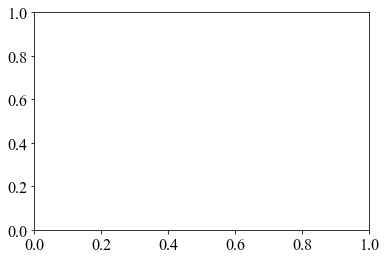

In [4]:
ex = 4

#ERROR = np.full(NCOV.shape, np.nan)
ALLRES = []

for j in range(0,NCOV.shape[0]):
    for k in range(0,NCOV.shape[1]):
        
        print('Case: ', NCOV[j,k], SSGLEN[j,k])
        
        regr_subseg_length_hrs = SSGLEN[j,k]
        regr_seg_gap_hrs = regr_subseg_length_hrs 
        obsErr = NCOV[j,k]*707.106781186548**2 # [m^2] (variance from actul position) the observation error must be less than the senFRr! 

        ex_derr_aemn = []
        ex_derr_algo = []

        ex_num_seen_aemn = []
        ex_num_seen_algo = []

        ensTracks = ensemble_data[ex]
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = np.delete(ensTracks, 0, 1)
        ensTracks = ensTracks.reshape(nens, ntst, 4)

        bestTrack = bestLabelTest_data[ex]
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = np.delete(bestTrack, 0, 1)
        bestTrack = bestTrack.reshape( ntst, 4)

        aemnTrack = meanEnsTest_data[ex]
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = np.delete(aemnTrack, 0, 1)
        aemnTrack = aemnTrack.reshape(ntst, 4)

        algo_results = algo(ensTracks, bestTrack, aemnTrack, obs_times, senFPr, obsErr, forecast_periods, nens,
                            extrpl_lastKnown_thresh, regr_seg_gap_hrs, regr_subseg_length_hrs, wetp, r_f, extrpl_numKnown_thresh)        
        
        ALLRES.append(algo_results)
        #ERROR[j,k] = algo_results['error_wna']
        
ALLRES = np.array(ALLRES)
ALLRES = ALLRES.reshape(NCOV.shape[0], NCOV.shape[1])
       
with open('sim_data/test_noise_vs_subseglen_ex'+str(ex)+'.pickle', 'wb') as handle:
            pickle.dump(ALLRES, handle, protocol=pickle.HIGHEST_PROTOCOL)  



## Visualize results

In [5]:
ex = 4
bestTrack = bestLabelTest_data[ex]
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = np.delete(bestTrack, 0, 1)
bestTrack = bestTrack.reshape( ntst, 4)

bt_x = list(bestTrack[:,2]) # get best-track info for the kth dataset
bt_y = list(bestTrack[:,3])
bt_t = forecast_periods


In [6]:
with open('sim_data/test_noise_vs_subseglen_ex4.pickle', 'rb') as handle:
    ALLRES = pickle.load(handle)

ERROR = np.full(NCOV.shape, np.nan)
KSPVARX = np.full(NCOV.shape, np.nan)
KSPVARY = np.full(NCOV.shape, np.nan)

for j in range(0, ALLRES.shape[0]):
    for k in range(0, ALLRES.shape[1]):
        ERROR[j,k] = ALLRES[j,k]['error_wna']
        obsti = ALLRES[j,k]['known_storm_position'][:,2]
        bt_pos_ksp = track_position_akima(bt_x, bt_y, bt_t, obsti)
        KSPVARX[j,k] = np.var(ALLRES[j,k]['known_storm_position'][:,0] - bt_pos_ksp[0])
        KSPVARY[j,k] = np.var(ALLRES[j,k]['known_storm_position'][:,1] - bt_pos_ksp[1])
        

In [7]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


y = 6
    
plt.figure()
x = len(_ncov)-1 
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'rx--')
print(NCOV[:,x])

x = len(_ncov)-5 
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'b+--')
print(NCOV[:,x])

x = len(_ncov)-9
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'g.--')
print(NCOV[:,x])

x = len(_ncov)-13
plt.plot(SSGLEN[:,x][0:y], ERROR[:,x][0:y], 'c*--')
print(NCOV[:,x])

plt.xlabel('Sub-segment length [hrs]')
plt.ylabel('Average distance error [km]')

plt.xlim((0.4,3.1))
plt.ylim((0,20))

plt.legend(['900', '400', '100', '1'], frameon = False)

plt.show();
plt.savefig("sim_data/error_vs_sslen.svg")

<IPython.core.display.Javascript object>

[900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
[400. 400. 400. 400. 400. 400. 400. 400. 400. 400.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"


SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
plt.figure()
'''
x = len(_ssglen)-1
plt.plot(NCOV[x,:], ERROR[x,:], 'rx--')
print(SSGLEN[x,:])

x = len(_ssglen)-3
plt.plot(NCOV[x,:], ERROR[x,:], 'b.--')
print(SSGLEN[x,:])
'''
x = len(_ssglen)-5
plt.plot(NCOV[x,:], ERROR[x,:], 'r^--')
print(SSGLEN[x,:])

x = len(_ssglen)-7 
plt.plot(NCOV[x,:], ERROR[x,:], 'b*--')
print(SSGLEN[x,:])

x = len(_ssglen)-9
plt.plot(NCOV[x,:], ERROR[x,:], 'gx--')
print(SSGLEN[x,:])

plt.xlabel('TC center measurement noise covariance [sq km]')
plt.ylabel('Average distance error [km]')

#plt.xlim((0,400))
#plt.ylim((2,9))
plt.legend(['3hrs','2hrs', '1hr'], frameon = False)
plt.show();
#plt.savefig("sim_data/error_vs_noise.svg")

<IPython.core.display.Javascript object>

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<IPython.core.display.Javascript object>


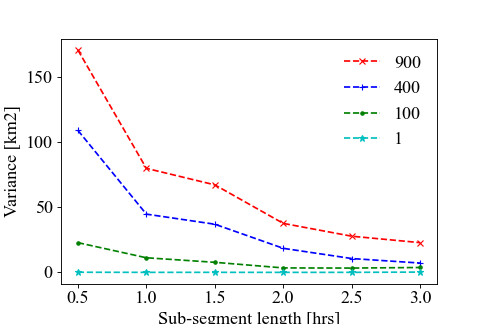

[900. 900. 900. 900. 900. 900. 900. 900. 900. 900.]
[400. 400. 400. 400. 400. 400. 400. 400. 400. 400.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

y = 6
    
plt.figure()
x = len(_ncov)-1 
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'rx--')
print(NCOV[:,x])

x = len(_ncov)-5 
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'b+--')
print(NCOV[:,x])

x = len(_ncov)-9
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'g.--')
print(NCOV[:,x])

x = len(_ncov)-13
plt.plot(SSGLEN[:,x][0:y], KSPVARX[:,x][0:y]*1e-6, 'c*--')
print(NCOV[:,x])

plt.xlabel('Sub-segment length [hrs]')
plt.ylabel('Variance [km2]')



plt.legend(['900', '400', '100', '1'], frameon = False)

plt.show();
#plt.savefig("sim_data/error_vs_sslen.svg")